## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import numpy as np

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [3]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

    data_from_site = {"env": my_env,
                      "name": "from_site",
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site = Site(**data_from_site)

    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": "to_site",
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)

    vessels = {}

    for i in range(NR_BARGES):
        vessels[f"vessel{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"barge_{i}",
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=f"cutter",
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels['cutter'] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        amount = np.random.randint(4,6) # handle loading
        duration=np.random.randint(2000,3000) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle{i}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[f"vessel{i}"]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        mover=vessels[f"vessel{i}"],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[f"vessel{i}"],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        mover=vessels[f"vessel{i}"],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        processor=vessels[f"vessel{i}"],
                        origin=vessels[f"vessel{i}"],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "from_site":from_site,
        "to_site":to_site,
    }


In [4]:
%%time
nbarges = 3
total_amount = 100
res = run(nbarges,total_amount)
vessels = res['vessels']
activities = res['activities']
cutter = vessels['cutter']
to_site = res['to_site']
from_site = res['from_site']

CPU times: user 77.9 ms, sys: 26.4 ms, total: 104 ms
Wall time: 85.6 ms


In [5]:
fig = plot.get_gantt_chart(vessels, id_map=activities)

In [6]:
fig = plot.get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [7]:
def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa
all_activities = []
for a in [*activities]:
    all_activities+=expand(activities[a],'load')
all_activities
fig = plot.get_gantt_chart(all_activities)

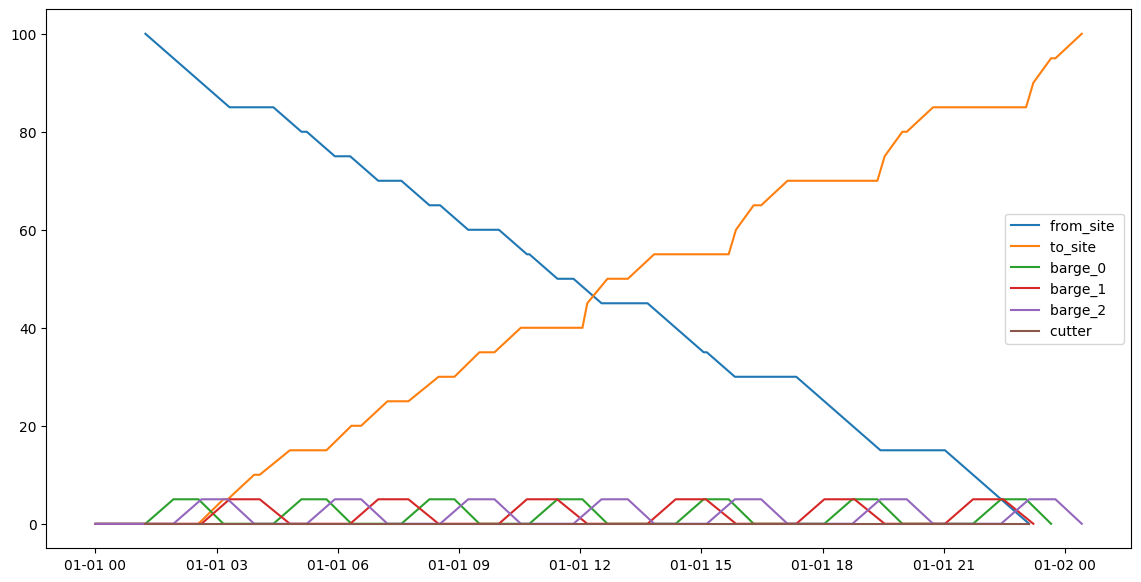

In [8]:
fig = plot.get_step_chart([from_site, to_site, *vessels.values()])

In [14]:
data = []
duration_theory_cutter = 0
nr_trips_cutter = 0

# barges
for i in range(len(vessels.values()) - 1):
    vessel = vessels[f'vessel{i}']
    activity = activities[f'activity{i}']
    sub_act = activity.sub_processes[0].sub_processes[-1] # loading (joint cutter-barge act)
    duration_theory_cutter += sub_act.duration*nr_trips
    
    log = pd.DataFrame(vessel.log)
    nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "START")])
    nr_trips_cutter += nr_trips
    
    # duration_theory = 4*sub_act.duration+ 5*sub_act.amount # ??????
    duration_theory = 0
    for sub_act in activity.sub_processes[0].sub_processes:
        duration_theory+=sub_act.duration
    
    duration_actual = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
    data.append({
        'name':vessel.name, 
        '# trips':nr_trips, 
        'production actual':(nr_trips * sub_act.amount) / (duration_actual),
        'production theory': (sub_act.amount / (duration_theory)),
    })
    
# cutter
log = pd.DataFrame(cutter.log)
duration_actual_cutter = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
data.append({
    'name':'cutter', 
    '# trips':nr_trips_cutter, 
    'production actual':(total_amount) / (duration_actual_cutter),
    'production theory':(total_amount) / (duration_theory_cutter),
})
    
df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
df['occupancy [%]'] = [f'{x:.1f}%' for x in 100*df['production actual']/df['production theory']]
df

,name,# trips,production actual,production theory,occupancy [%]
3,cutter,20,0.001270,0.002063,61.6%
0,barge_0,7,0.000411,0.000438,93.8%
2,barge_2,7,0.000398,0.000421,94.6%
1,barge_1,6,0.000359,0.000377,95.1%
